# Visualize PMP Modes of Variability results: CMIP6

In this document, you will visualize PMP's Modes of Variability results for CMIP6, to inter-compare performace. You will create following plots.
- Portrait plot 
- Parallel coordinate plot

Written by Jiwoo Lee (LLNL/PCMDI)

Last update: Nov 2024

## Contents

1. [Read data from JSON files](#read)
  - 1.1 [Download PMP output JSON files for CMIP models](#download)
  - 1.2 [Normalize each column by its median for portrait plot](#normalize)
2. [Portrait Plot](#portrait)
3. [Parallel Coordinate Plot](#parallel)

## 1. Read data from JSON files <a name="read"></a>

Input data for portrait plot is expected as a set a (stacked or list of) 2-d numpy array(s) with list of strings for x and y axes labels. 

### 1.1 Download PMP output JSON files for CMIP models <a name="download"></a>

In [1]:
import glob
import json
import os
import pandas as pd
import numpy as np

from pcmdi_metrics.graphics import download_archived_results
from pcmdi_metrics.utils import sort_human

PMP output files downloadable from the [PMP results archive](https://github.com/PCMDI/pcmdi_metrics_results_archive).

In [2]:
modes = ['NAM', 'NAO', 'NPGO', 'NPO', 'PDO', 'PNA', 'SAM']

json_dir = './json_files'

mip = "cmip6"
exp = "historical"
data_version = "v20220825"

"""
mip = "cmip5"
exp = "historical"
data_version = "v20210119"
"""

"""
mip = "cmip3"
exp = "20cm3"
data_version = "v20210119"
"""

stat = "rms"
#stat = "rmsc"
#stat = "stdv_pc_ratio_to_obs"

In [3]:
if stat == "rms":
    stat_name = "RMSE"
elif stat == "rmsc":
    stat_name = "Centered RMSE"
elif stat == "stdv_pc_ratio_to_obs":
    stat_name = "Amplitude ratio to OBS"

Provide directory path and filename in the [PMP results archive](https://github.com/PCMDI/pcmdi_metrics_results_archive).

In [4]:
for mode in modes:
    if mode in ['PDO', 'NPGO']:
        ref = "HadISSTv1.1"
    else:
        ref = "NOAA-CIRES_20CR"
        
    if mode in ['NPO', 'NPGO']:
        eof = "EOF2"
    else:
        eof = "EOF1"
               
    path = os.path.join("metrics_results/variability_modes/"+mip+"/"+exp+"/"+data_version,
                        mode, ref,
                        "_".join(["var", "mode", mode, eof, "stat", mip, exp, "mo_atm_allModels_allRuns_1900-2005.json"]))
    download_archived_results(path, json_dir)

Check JSON files

In [5]:
json_list = sorted(glob.glob(os.path.join(json_dir, 'var_mode_*' + mip + '*' + '.json')))
for json_file in json_list:
    print(json_file.split('/')[-1])

var_mode_NAM_EOF1_stat_cmip6_historical_mo_atm_allModels_allRuns_1900-2005.json
var_mode_NAO_EOF1_stat_cmip6_historical_mo_atm_allModels_allRuns_1900-2005.json
var_mode_NPGO_EOF2_stat_cmip6_historical_mo_atm_allModels_allRuns_1900-2005.json
var_mode_NPO_EOF2_stat_cmip6_historical_mo_atm_allModels_allRuns_1900-2005.json
var_mode_PDO_EOF1_stat_cmip6_historical_mo_atm_allModels_allRuns_1900-2005.json
var_mode_PNA_EOF1_stat_cmip6_historical_mo_atm_allModels_allRuns_1900-2005.json
var_mode_SAM_EOF1_stat_cmip6_historical_mo_atm_allModels_allRuns_1900-2005.json


In [6]:
cmip_result_dict = dict()
modes = list()

for json_file in json_list:
    mode = json_file.split('/')[-1].split('_')[2]
    modes.append(mode)
    with open(json_file) as fj:
        dict_temp = json.load(fj)['RESULTS']
        cmip_result_dict[mode] = dict_temp

In [ ]:
def dict_to_df(cmip_result_dict):
    models = sorted(list(cmip_result_dict['NAM'].keys()))

    df = pd.DataFrame()
    df['model'] = models
    df['num_runs'] = np.nan
    
    mode_season_list = list()

    modes = ['SAM', 'NAM', 'NAO', 'NPO', 'PNA', 'NPGO', 'PDO']
    for mode in modes:
        if mode in ['PDO', 'NPGO']:
            seasons = ['monthly']
        else:
            seasons = ['DJF', 'MAM', 'JJA', 'SON']

        for season in seasons:
            df[mode+"_"+season] = np.nan
            mode_season_list.append(mode+"_"+season)
            for index, model in enumerate(models):
                if model in list(cmip_result_dict[mode].keys()):
                    runs = sort_human(list(cmip_result_dict[mode][model].keys()))
                    stat_run_list = list()
                    for run in runs:
                        stat_run = cmip_result_dict[mode][model][run]['defaultReference'][mode][season]['cbf'][stat]
                        stat_run_list.append(stat_run)    
                    stat_model = np.average(np.array(stat_run_list))
                    num_runs = len(runs)
                    df.at[index, mode+"_"+season] = stat_model
                    if np.isnan(df.at[index, 'num_runs']):
                        df.at[index, 'num_runs'] = num_runs
                else:
                    stat_model = np.nan
                    num_runs = 0
    return df, mode_season_list

In [8]:
df, mode_season_list = dict_to_df(cmip_result_dict)
df

,model,num_runs,SAM_DJF,SAM_MAM,SAM_JJA,SAM_SON,NAM_DJF,NAM_MAM,NAM_JJA,NAM_SON,...,NPO_DJF,NPO_MAM,NPO_JJA,NPO_SON,PNA_DJF,PNA_MAM,PNA_JJA,PNA_SON,NPGO_monthly,PDO_monthly
0,ACCESS-CM2,5.0,0.574046,0.380609,0.544973,0.391616,0.571041,0.459388,0.240580,0.342555,...,0.732129,0.460701,0.288707,0.306164,0.650744,0.569345,0.286248,0.256308,0.136352,0.122066
1,ACCESS-ESM1-5,40.0,0.602834,0.414287,0.608346,0.610213,0.506217,0.412721,0.264908,0.354789,...,0.579083,0.350249,0.269973,0.241847,0.476215,0.388328,0.269333,0.287768,0.126786,0.124546
2,AWI-CM-1-1-MR,5.0,0.508376,0.366660,0.796009,0.917559,0.587488,0.392637,0.228123,0.323303,...,0.682399,0.413841,0.224981,0.406585,0.714271,0.464686,0.276964,0.328163,0.112087,0.136091
3,AWI-ESM-1-1-LR,1.0,0.544485,0.398040,0.634991,1.008028,0.802982,0.475390,0.257938,0.404807,...,1.065016,0.574711,0.268740,0.307862,1.031246,0.445994,0.295466,0.302287,0.113582,0.194669
4,BCC-CSM2-MR,3.0,0.465351,0.420144,0.624178,0.645676,0.718848,0.728025,0.403785,0.701120,...,0.763210,0.769850,0.500015,0.591631,0.790271,0.886669,0.483820,0.563353,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,NorESM2-MM,3.0,0.486581,0.399562,0.656545,0.633588,0.548388,0.588263,0.309797,0.411143,...,0.307830,0.447543,0.384719,0.251864,0.633810,0.720310,0.375183,0.338101,0.105681,0.186747
61,SAM0-UNICON,1.0,0.511490,0.412573,0.708228,0.679179,0.619961,0.641307,0.233174,0.375586,...,0.582020,0.343711,0.288251,0.473160,0.684519,0.619769,0.267318,0.387104,0.137859,0.133782
62,TaiESM1,2.0,0.469439,0.392923,0.598709,0.523395,0.669217,0.616860,0.276326,0.450474,...,0.339072,0.337362,0.336802,0.414093,0.580974,0.631163,0.306005,0.524750,0.137300,0.136674
63,UKESM1-0-LL,19.0,0.586528,0.352492,0.513565,0.476506,0.520315,0.506951,0.227039,0.312856,...,0.673702,0.556370,0.251275,0.250827,0.597751,0.644911,0.240213,0.237588,0.146209,0.145564


In [9]:
df_combined = df

In [10]:
model_labels = [m + ' (' + str(int(r)) + ')' for m, r in zip(df_combined["model"].to_list(), df_combined["num_runs"].to_list())]

#### Prepare input for portrait plot plotting function

In [11]:
landscape = True
#landscape = False

data = dict()

if landscape:
    data = df_combined[mode_season_list].to_numpy().T
else:
    data = df_combined[mode_season_list].to_numpy()

In [12]:
models = df_combined.index.values.tolist()

print('data.shape:', data.shape)
print('len(mode_season_list): ', len(mode_season_list))
print('len(models): ', len(models))

data.shape: (22, 65)
len(mode_season_list):  22
len(models):  65


In [13]:
if landscape:
    yaxis_labels = mode_season_list
    xaxis_labels = model_labels
else:
    xaxis_labels = mode_season_list
    yaxis_labels = model_labels

### 1.2 Normalize each column by its median for portrait plot <a name="normalize"></a>

Use `normalize_by_median` function.

#### Parameters
- `data`: 2d numpy array
- `axis`: 0 (normalize each column) or 1 (normalize each row), default=0 

#### Return
- `data_nor`: 2d numpy array

In [14]:
if landscape:
    axis = 1
    figsize = (40, 10)
else:
    axis = 0
    figsize = (18, 25)

In [15]:
from pcmdi_metrics.graphics import normalize_by_median

if stat not in ["stdv_pc_ratio_to_obs"]:
    data_nor = normalize_by_median(data, axis=axis)
    cmap_bounds = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
    vertical_center = "median"
    cmap = 'RdYlBu_r'
else:
    data_nor = data
    cmap_bounds = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
    cmap_bounds = [r/10 for r in range(5, 16, 1)]
    vertical_center = 1
    cmap = 'jet'

In [16]:
data_nor.shape

(22, 65)

## 2. Portrait Plot <a name="portrait"></a>

Use Matplotlib-based PMP Visualization Function. Detailed description for the functions parameters and returns can be found in the [API documentation](http://pcmdi.github.io/pcmdi_metrics/generated/pcmdi_metrics.graphics.portrait_plot.html#pcmdi_metrics.graphics.portrait_plot).

In [17]:
from pcmdi_metrics.graphics import portrait_plot

### Portrait Plot

Text(0.5, 1.0, 'Variability Modes: RMSE')

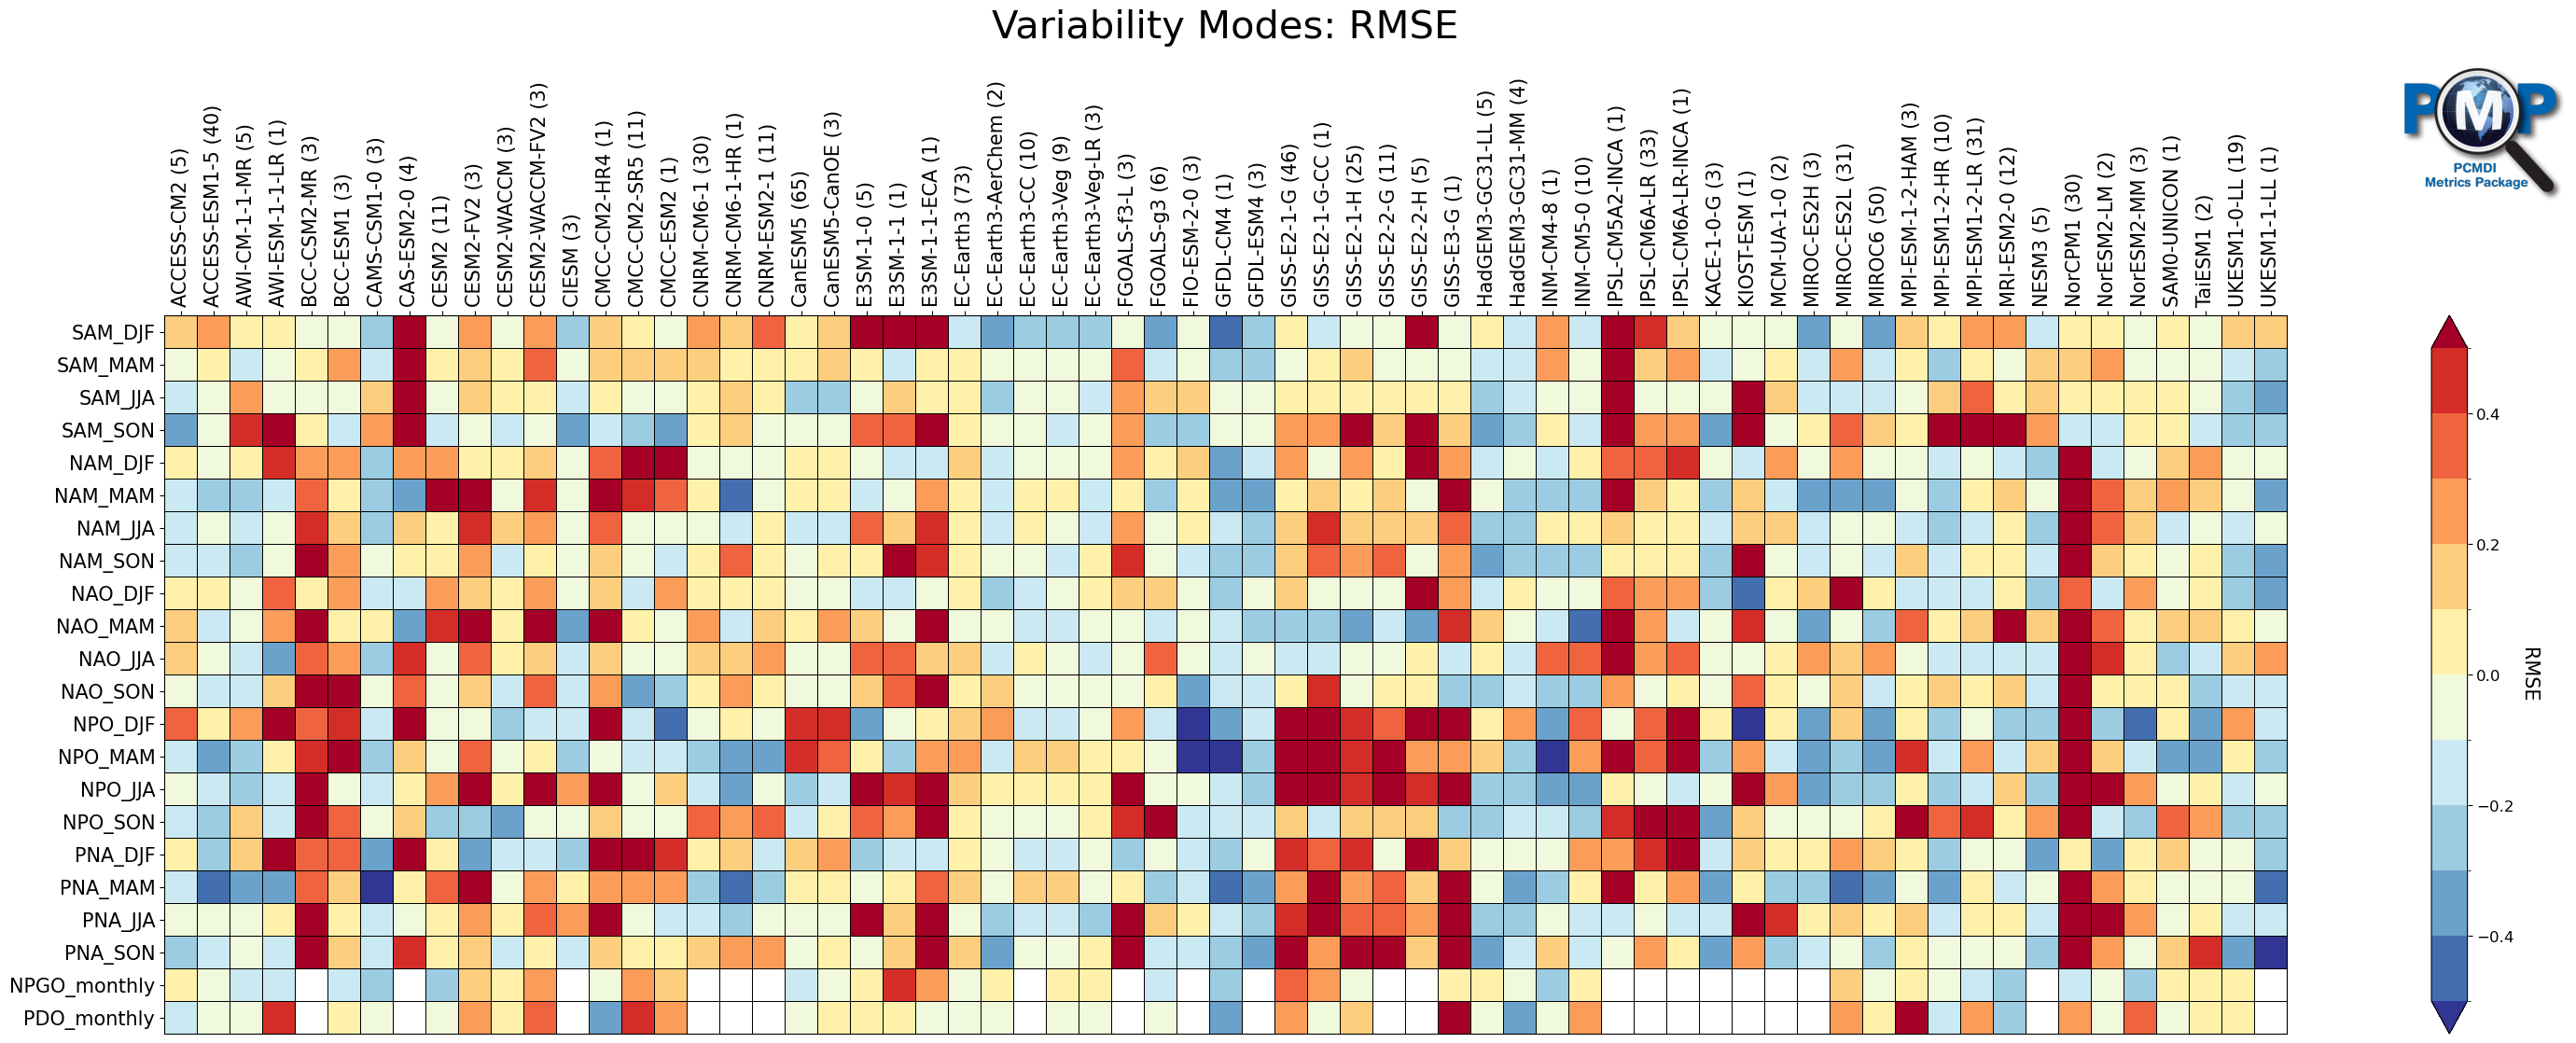

In [18]:
fig, ax, cbar = portrait_plot(data_nor,
                              xaxis_labels=xaxis_labels, 
                              yaxis_labels=yaxis_labels, 
                              cbar_label=stat_name,
                              box_as_square=True,
                              vrange=(-0.5, 0.5),
                              figsize=figsize,
                              cmap=cmap,
                              cmap_bounds=cmap_bounds,
                              cbar_kw={"extend": "both"},
                              missing_color='white',
                              legend_box_xy=(1.11, 1.21),
                              legend_box_size=4,
                              legend_lw=1,
                              legend_fontsize=15,
                              logo_rect = [0.67, 1, 0.15, 0.15],
                             )
ax.set_xticklabels(xaxis_labels, rotation=90, va='center', ha="left")

# Add title
ax.set_title("Variability Modes: "+stat_name, fontsize=30, pad=30)

In [19]:
# Save figure as an image file
fig.savefig('_'.join(['variability_modes_portrait_plot', mip, exp, stat])+'.png', facecolor='w', bbox_inches='tight')

## 3. Parallel Coordinate Plot <a name="parallel"></a>

In [20]:
data = df_combined[mode_season_list].to_numpy()
model_names = model_labels
metric_names = mode_season_list
model_highlights = None
print('data.shape:', data.shape)
print('len(metric_names): ', len(metric_names))
print('len(model_names): ', len(model_names))

data.shape: (65, 22)
len(metric_names):  22
len(model_names):  65


### Use parallel coordinate plot function of PMP

Detailed description for the functions parameters and returns can be found in the [API documentation](http://pcmdi.github.io/pcmdi_metrics/generated/pcmdi_metrics.graphics.parallel_coordinate_plot.html#pcmdi_metrics.graphics.parallel_coordinate_plot).

In [21]:
from pcmdi_metrics.graphics import parallel_coordinate_plot

### 3.1 Show all models

[Text(0, 0, 'SAM_DJF'),
 Text(1, 0, 'SAM_MAM'),
 Text(2, 0, 'SAM_JJA'),
 Text(3, 0, 'SAM_SON'),
 Text(4, 0, 'NAM_DJF'),
 Text(5, 0, 'NAM_MAM'),
 Text(6, 0, 'NAM_JJA'),
 Text(7, 0, 'NAM_SON'),
 Text(8, 0, 'NAO_DJF'),
 Text(9, 0, 'NAO_MAM'),
 Text(10, 0, 'NAO_JJA'),
 Text(11, 0, 'NAO_SON'),
 Text(12, 0, 'NPO_DJF'),
 Text(13, 0, 'NPO_MAM'),
 Text(14, 0, 'NPO_JJA'),
 Text(15, 0, 'NPO_SON'),
 Text(16, 0, 'PNA_DJF'),
 Text(17, 0, 'PNA_MAM'),
 Text(18, 0, 'PNA_JJA'),
 Text(19, 0, 'PNA_SON'),
 Text(20, 0, 'NPGO_monthly'),
 Text(21, 0, 'PDO_monthly')]

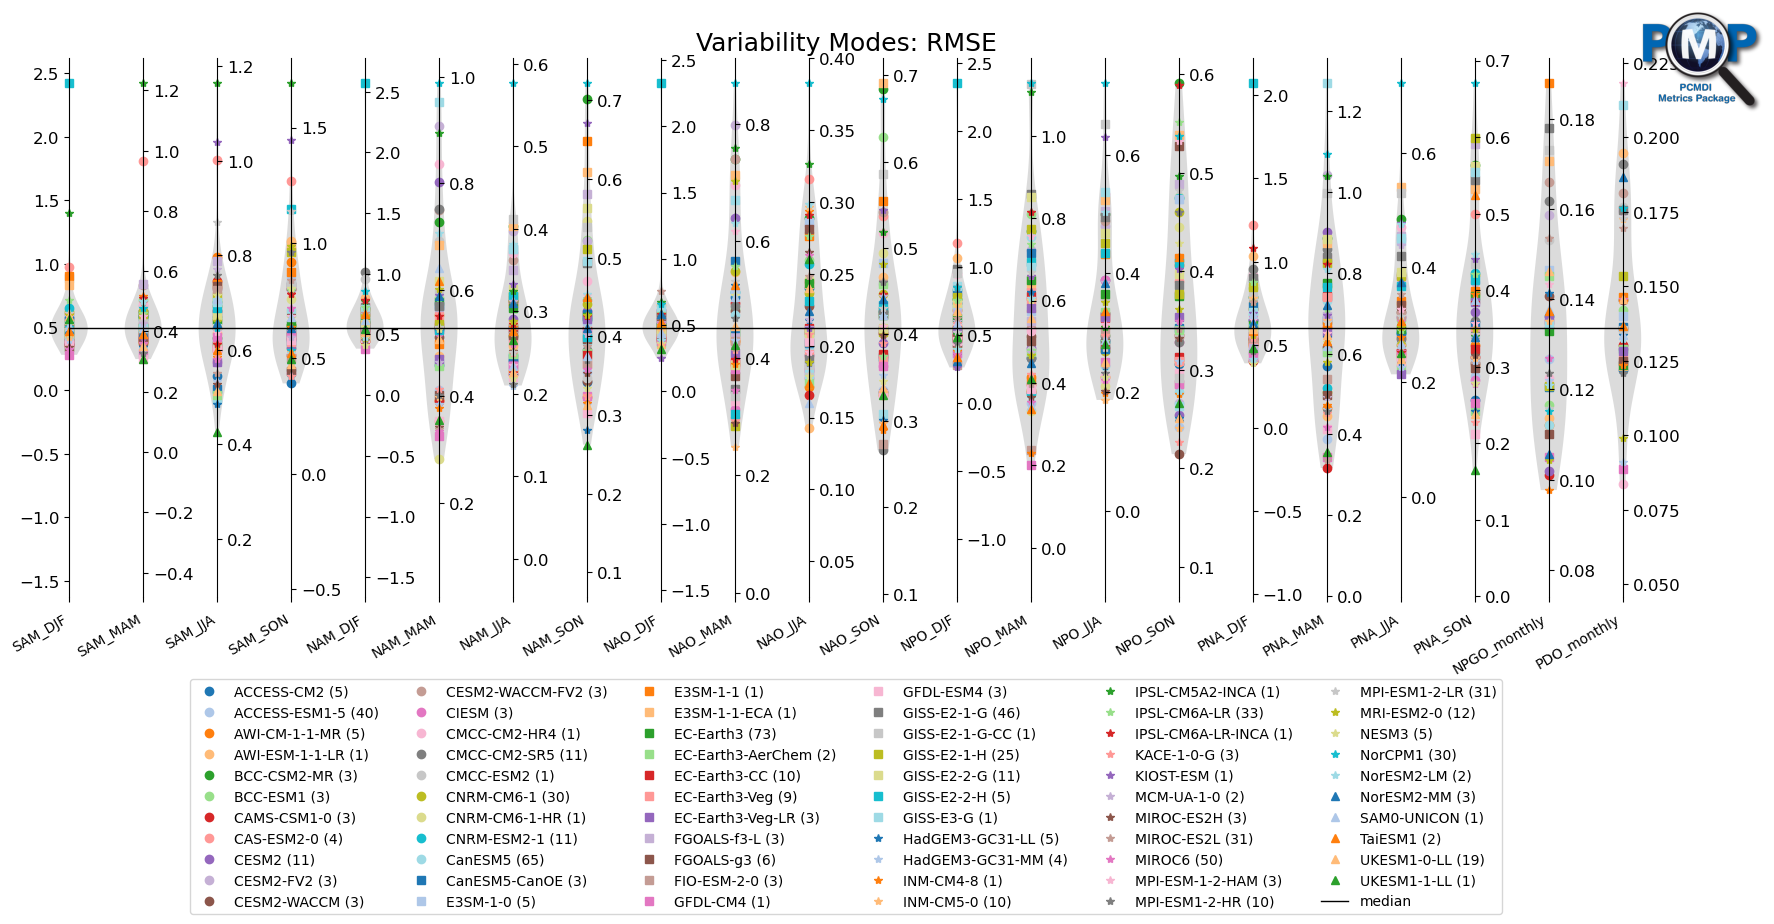

In [22]:
fig, ax = parallel_coordinate_plot(data, metric_names, model_names, 
                                   title='Variability Modes: '+stat_name, 
                                   figsize=(21, 7),
                                   colormap='tab20',
                                   show_boxplot=False,
                                   show_violin=True,
                                   violin_colors=("lightgrey", "pink"),
                                   xtick_labelsize=10,
                                   logo_rect=[0.8, 0.8, 0.15, 0.15],
                                   comparing_models=model_highlights,
                                   vertical_center=vertical_center,
                                   vertical_center_line=True
                                  )

ax.set_xticklabels(metric_names, rotation=30, va='top', ha="right")

In [23]:
# Save figure as an image file
fig.savefig('_'.join(['variability_modes_parallel_coordinate_plot', mip, exp, stat])+'.png', facecolor='w', bbox_inches='tight')

### 3.2 Highlight specific models

[Text(0, 0, 'SAM_DJF'),
 Text(1, 0, 'SAM_MAM'),
 Text(2, 0, 'SAM_JJA'),
 Text(3, 0, 'SAM_SON'),
 Text(4, 0, 'NAM_DJF'),
 Text(5, 0, 'NAM_MAM'),
 Text(6, 0, 'NAM_JJA'),
 Text(7, 0, 'NAM_SON'),
 Text(8, 0, 'NAO_DJF'),
 Text(9, 0, 'NAO_MAM'),
 Text(10, 0, 'NAO_JJA'),
 Text(11, 0, 'NAO_SON'),
 Text(12, 0, 'NPO_DJF'),
 Text(13, 0, 'NPO_MAM'),
 Text(14, 0, 'NPO_JJA'),
 Text(15, 0, 'NPO_SON'),
 Text(16, 0, 'PNA_DJF'),
 Text(17, 0, 'PNA_MAM'),
 Text(18, 0, 'PNA_JJA'),
 Text(19, 0, 'PNA_SON'),
 Text(20, 0, 'NPGO_monthly'),
 Text(21, 0, 'PDO_monthly')]

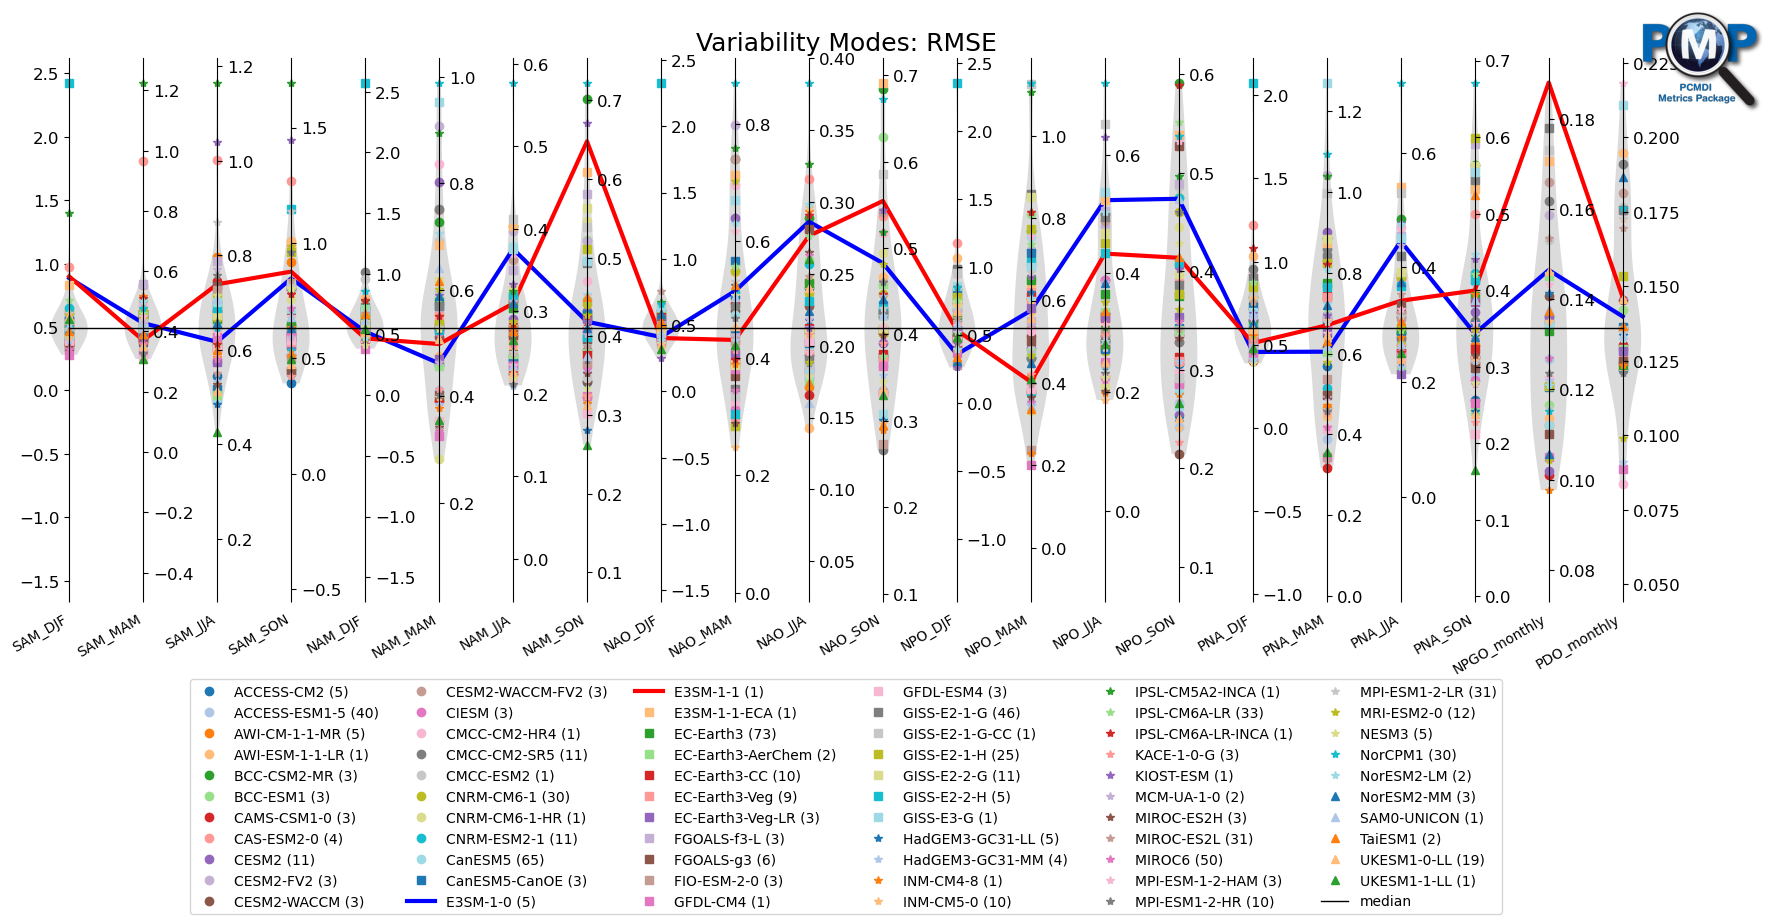

In [24]:
model_highlights = ['E3SM-1-0 (5)', 'E3SM-1-1 (1)']

fig, ax = parallel_coordinate_plot(data, metric_names, model_names, 
                                   models_to_highlight=model_highlights, 
                                   models_to_highlight_colors=['blue', 'red'],
                                   title='Variability Modes: '+stat_name, 
                                   figsize=(21, 7),
                                   colormap='tab20',
                                   show_boxplot=False,
                                   show_violin=True,
                                   violin_colors=("lightgrey", "pink"),
                                   xtick_labelsize=10,
                                   logo_rect=[0.8, 0.8, 0.15, 0.15],
                                   comparing_models=model_highlights,
                                   vertical_center=vertical_center,
                                   vertical_center_line=True
                                  )

ax.set_xticklabels(metric_names, rotation=30, va='top', ha="right")
